# 1d acoustic wave on a string test case

This notebook documents the process of developing a 1d string system with motion governed by the acoustic wave equation. We will use a pair of homogeneous Dirichlet boundary conditions as well as initial conditions for the position and velocity. The system is set up as follows:

$$
\frac{\partial^2 u(x,t)}{\partial t^2} = c^2 \frac{\partial^2 u(x,t)}{\partial x^2}, \quad x \in [-L, L], \, t > 0
$$

**Boundary conditions:**

$$
u(-L, t) = 0, \quad u(L, t) = 0
$$

**Initial conditions:**

$$
u(x, 0) = \sin(\frac{2 \pi  x}{L}), \quad u_{t}(x, 0) = 0
$$




In [29]:
# import modules
import numpy as np
import matplotlib.pyplot as plt

### Wave equation analytical solution 

The system above has a general solution given by:

$$ u(x, t) = \sum_{n=1}^{\infty} \sin(\frac{n \pi x}{L})[A_n \cos(\frac{c n \pi t}{L}) + B_n \sin(\frac{c n \pi t}{L})] $$

Applying the initial conditions to find $A_n$ and $B_n$ yields: 

$$ A_n = \frac{2}{L} \int_{-L}^{L} \sin(\frac{2 \pi x}{L}) \sin(\frac{n \pi x}{L}) dx $$

$$ B_n = 0 $$


Evaluating the integral leads us to an analytical solution of:

$$ u(x, t) = \cos(\frac{2 \pi c t}{L}) \sin(\frac{2 \pi x}{L}) $$

Below we plot the initial position of the wave alongside the solution at different time steps, we take $c$ as 1000 m/s leading to a period of 1 second for a length $L$ = 1000m

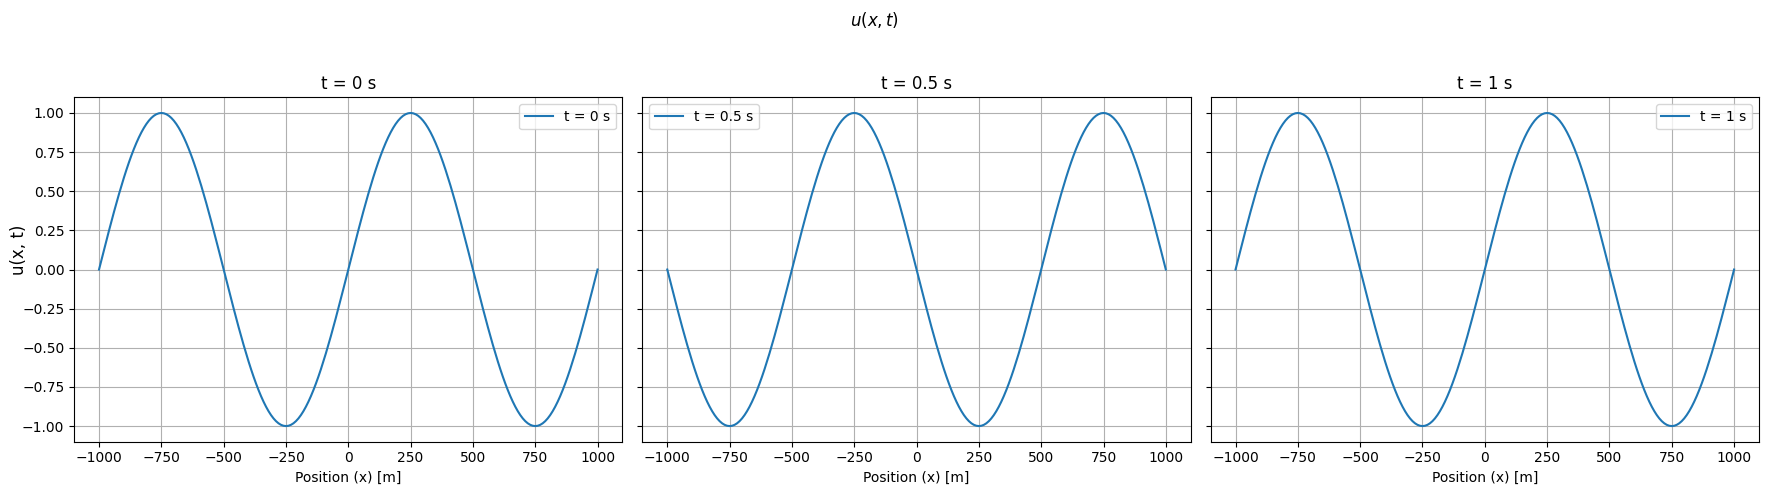

In [30]:
# define constants 
L = 1000
c = 1000
t_values = [0, 0.5, 1]
x = np.linspace(-L, L, 201)

# define analytical solution 
def u(x, t, c, L):
    return np.cos(2*np.pi*c*t/L)*np.sin(2*np.pi*x/L)

# set up the figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# plot the wave solution at each specified time step in side-by-side subplots
for i, t in enumerate(t_values):
    axs[i].plot(x, u(x, t, c, L), label=f"t = {t} s")
    axs[i].set_xlabel("Position (x) [m]")
    axs[i].set_title(f"t = {t} s")
    axs[i].legend()
    axs[i].grid(True)

# set the y-axis label for the entire figure
fig.supylabel("u(x, t)")
fig.suptitle("$u(x, t)$")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Solving the equation numerically using a finite difference method with a space order of 2

Here, we apply a forward Euler scheme to solve the PDE system numerically. We apply a time and space order of 2 in this case, with 200 grid points across a 2000m physical domain with a velocity $c$ of 1000m/s.

We use a second order central difference approximation for the time and spatial derivatives to construct our stencil:

$$ \frac{\partial^2 u}{\partial t^2} \approx \frac{u^{n+1}_i - 2 u^n_i + u^{n-1}_i}{(\Delta t)^2} $$

$$ \frac{\partial^2 u}{\partial x^2} \approx \frac{u^n_{i+1} - 2 u^n_i + u^n_{i-1}}{(\Delta x)^2} $$

Substituting these approximations in for the derivatives in the equation leads to:

$$ \frac{u^{n+1}_i - 2 u^n_i + u^{n-1}_i}{(\Delta t)^2} = c^2 \frac{u^n_{i+1} - 2 u^n_i + u^n_{i-1}}{(\Delta x)^2} $$

Re-arranging for $u_{i}^{n+1}$ then yields our finite difference stencil that we implement:

$$ u^{n+1}_i = 2 u^n_i - u^{n-1}_i + \left( \frac{c \Delta t}{\Delta x} \right)^2 \left( u^n_{i+1} - 2 u^n_i + u^n_{i-1} \right) $$

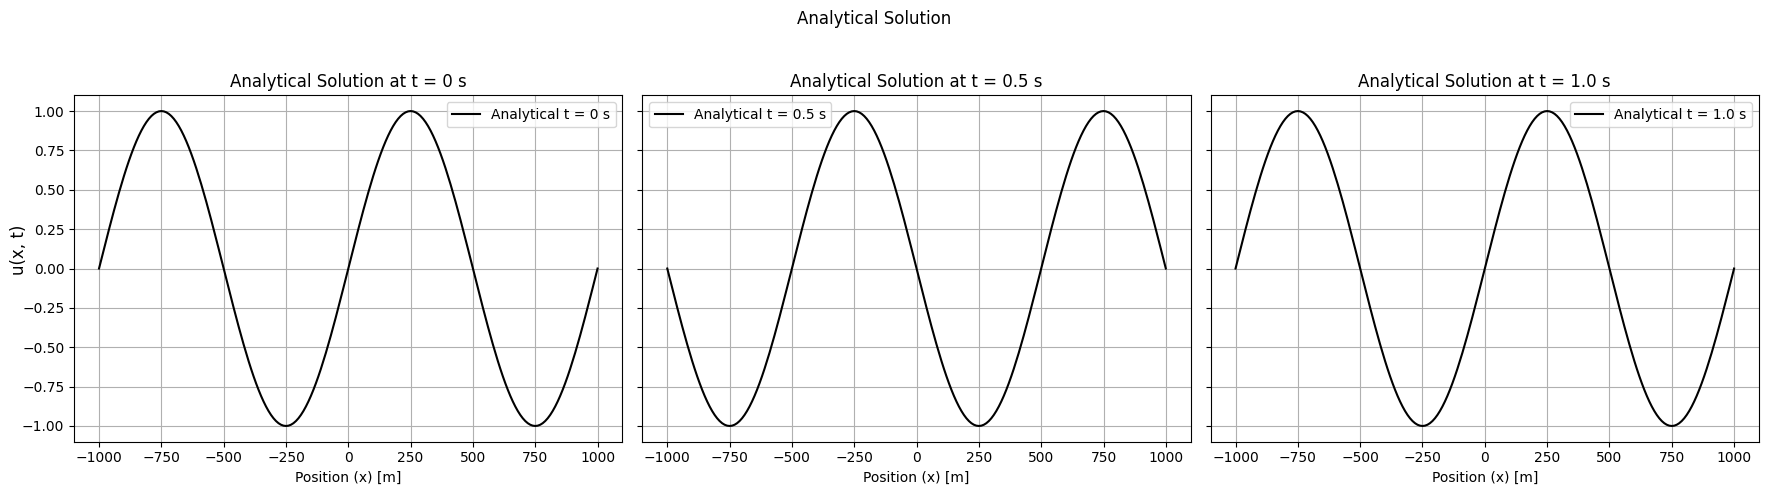

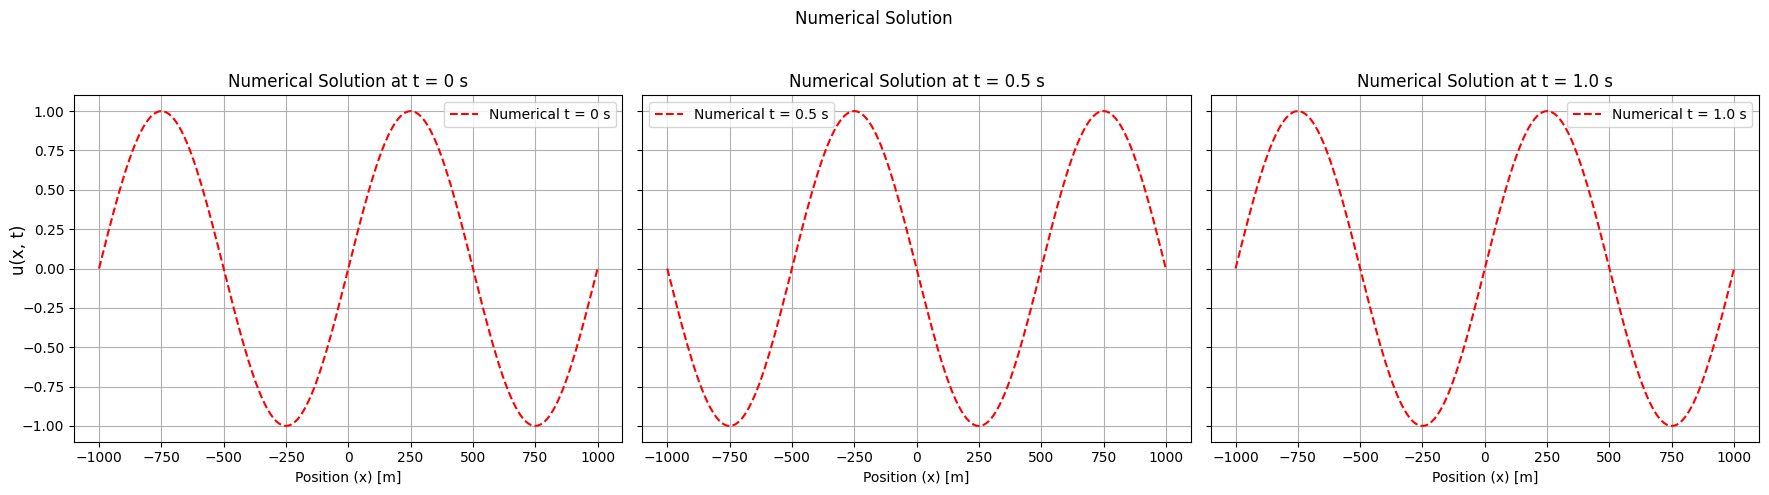

In [31]:
# Constants
L = 1000                 # Half-length of the domain in meters
c = 1000                 # Wave speed in m/s
N = 201                  # Number of spatial points
dx = 2 * L / (N - 1)     # Spatial step size for [-L, L] domain
dt = 0.9 * dx / c        # Time step size (CFL condition)
T = 1.0                  # Total simulation time in seconds
x = np.linspace(-L, L, N) # Spatial grid

# Total time steps
Nt = int(T / dt) + 1

# Initialize the wave field
u = np.sin(2 * np.pi * x / L)        # Initial condition u(x, 0)
u_prev = u.copy()                    # Initial velocity is zero: u_t(x, 0) = 0, so u at t=-1 = u at t=0
u_next = np.zeros(N)                 # Placeholder for the next time step

# Storage for specific time indices based on dt intervals
# Store the solutions at integer time indices corresponding to t = 0, 0.5, and 1.0 seconds
time_steps = [0, int(0.5 / dt), int(1.0 / dt)]
u_num_at_t = {}

# Main time evolution loop
for n in range(Nt):
    # Store the results for specific time indices
    if n in time_steps:
        u_num_at_t[n] = u.copy()  # Store the wave profile at the specified time step indices
    
    # Compute the next time step using finite difference
    for i in range(1, N - 1):
        u_next[i] = (2 * u[i] - u_prev[i] +
                     (c * dt / dx) ** 2 * (u[i + 1] - 2 * u[i] + u[i - 1]))

    # Apply boundary conditions
    u_next[0] = u_next[-1] = 0

    # Update arrays for the next time step
    u_prev = u.copy()
    u = u_next.copy()

# Analytical Solution
def analytical_solution(x, t, c, L):
    return np.cos(2 * np.pi * c * t / L) * np.sin(2 * np.pi * x / L)

## Plotting the analytical solution
fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, t in enumerate([0, 0.5, 1.0]):
    # Analytical solution at time t
    u_analytic = analytical_solution(x, t, c, L)
    axs1[i].plot(x, u_analytic, 'k-', label=f"Analytical t = {t} s")

    # Plot formatting
    axs1[i].set_xlabel("Position (x) [m]")
    axs1[i].set_title(f"Analytical Solution at t = {t} s")
    axs1[i].legend()
    axs1[i].grid(True)

# Set global y-axis label
fig1.supylabel("u(x, t)")
fig1.suptitle("Analytical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Plotting the numerical solution
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
# Map the specified times to the stored integer time indices
time_map = {0: 0, 0.5: int(0.5 / dt), 1.0: int(1.0 / dt)}

for i, t in enumerate([0, 0.5, 1.0]):
    # Retrieve the numerical solution for the mapped time index
    u_num = u_num_at_t[time_map[t]]
    axs2[i].plot(x, u_num, 'r--', label=f"Numerical t = {t} s")

    # Plot formatting
    axs2[i].set_xlabel("Position (x) [m]")
    axs2[i].set_title(f"Numerical Solution at t = {t} s")
    axs2[i].legend()
    axs2[i].grid(True)

# Set global y-axis label
fig2.supylabel("u(x, t)")
fig2.suptitle("Numerical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


### Testing the accuracy of the numerical solver above

Here we test the accuracy of the numerical solver by computing some common comparison metrics to see the difference between the numerical and analytical solutions.

In [32]:
# Define tolerances
rtol = 1e-4
atol = 1e-5

# Times to check
times_to_check = [0, 0.5, 1.0]
time_map = {0: 0, 0.5: int(0.5 / dt), 1.0: int(1.0 / dt)}

# Check if numerical and analytical solutions match and report differences
for t in times_to_check:
    # Numerical and analytical solutions at this time step
    u_num = u_num_at_t[time_map[t]]
    u_analytic = analytical_solution(x, t, c, L)
    
    # Check if they are close
    is_close = np.all(np.isclose(u_num, u_analytic, rtol=rtol, atol=atol))
    
    if not is_close:
        # Calculate different error metrics
        max_abs_error = np.max(np.abs(u_num - u_analytic))
        mean_abs_error = np.mean(np.abs(u_num - u_analytic))
        rmse = np.sqrt(np.mean((u_num - u_analytic) ** 2))
        relative_error = np.mean(np.abs((u_num - u_analytic) / (u_analytic + 1e-10))) * 100  # avoid division by zero
        
        print(f"At t = {t} s:")
        print(f"  - Max Absolute Error: {max_abs_error:.6f}")
        print(f"  - Mean Absolute Error (MAE): {mean_abs_error:.6f}")
        print(f"  - Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"  - Average Relative Error: {relative_error:.2f}%")
    else:
        print(f"At t = {t} s: Numerical and analytical solutions are within tolerance.")


At t = 0 s: Numerical and analytical solutions are within tolerance.
At t = 0.5 s:
  - Max Absolute Error: 0.000395
  - Mean Absolute Error (MAE): 0.000250
  - Root Mean Squared Error (RMSE): 0.000278
  - Average Relative Error: 0.04%
At t = 1.0 s:
  - Max Absolute Error: 0.000162
  - Mean Absolute Error (MAE): 0.000103
  - Root Mean Squared Error (RMSE): 0.000114
  - Average Relative Error: 0.02%


### Implementing a numerical solver with space order 4

When discretising our equation, choosing a higher order approximation for the spatial derivative yields a new stencil.

$$ \frac{\partial^2 u}{\partial t^2} \approx \frac{u^{n+1}_i - 2 u^n_i + u^{n-1}_i}{\Delta t^2} $$

$$ \frac{\partial^2 u}{\partial x^2} \approx \frac{- u^n_{i-2} 16 u^n_{i-1} - 30 u^n_i + 16 u^n_{i+1} - u^n_{i+2}}{12 \Delta x^2} $$

Substituting these approximations in for the derivatives in the equation leads to:

$$ \frac{u^{n+1}_i - 2 u^n_i + u^{n-1}_i}{\Delta t^2} = c^2 \frac{- u^n_{i-2} 16 u^n_{i-1} - 30 u^n_i + 16 u^n_{i+1} - u^n_{i+2}}{12 \Delta x^2} $$

Re-arranging for $u_{i}^{n+1}$ then yields our finite difference stencil that we implement:

$$ u^{n+1}_i = 2 u^n_i - u^{n-1}_i + \frac{c^2 \Delta t^2}{12 \Delta x^2}  \left(- u^n_{i-2} + 16 u^n_{i-1} - 30 u^n_i + 16 u^n_{i+1} - u^n_{i+2} \right) $$

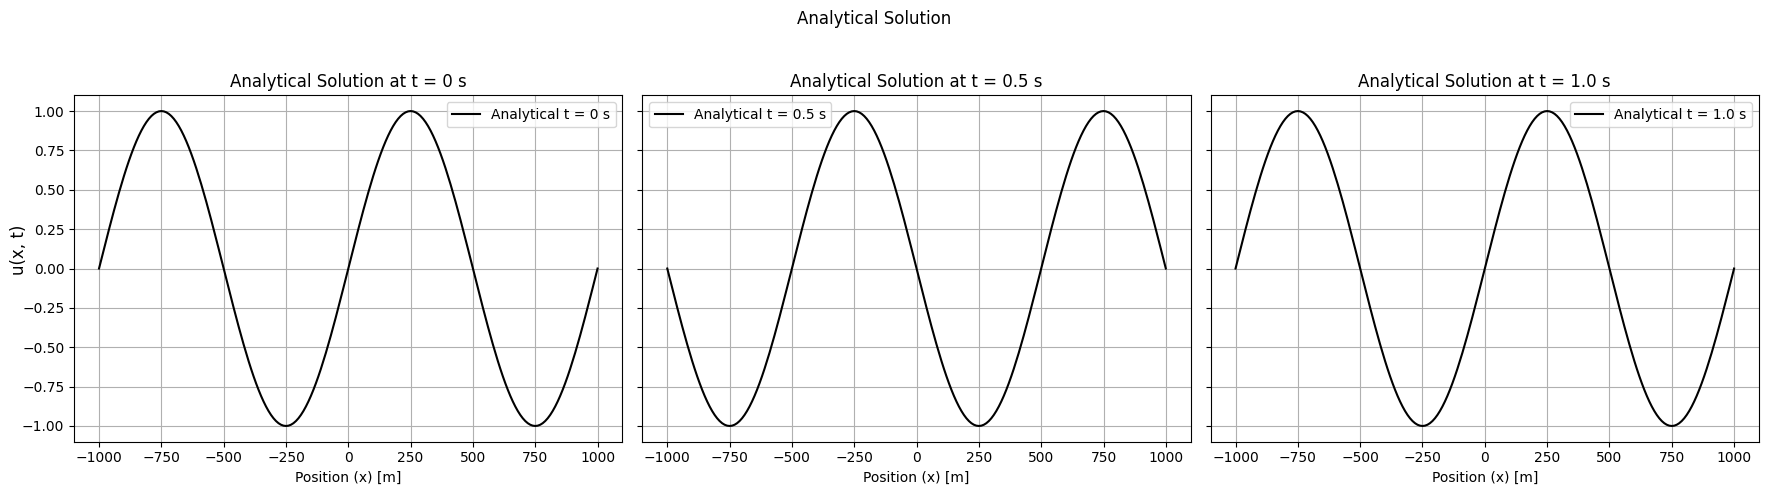

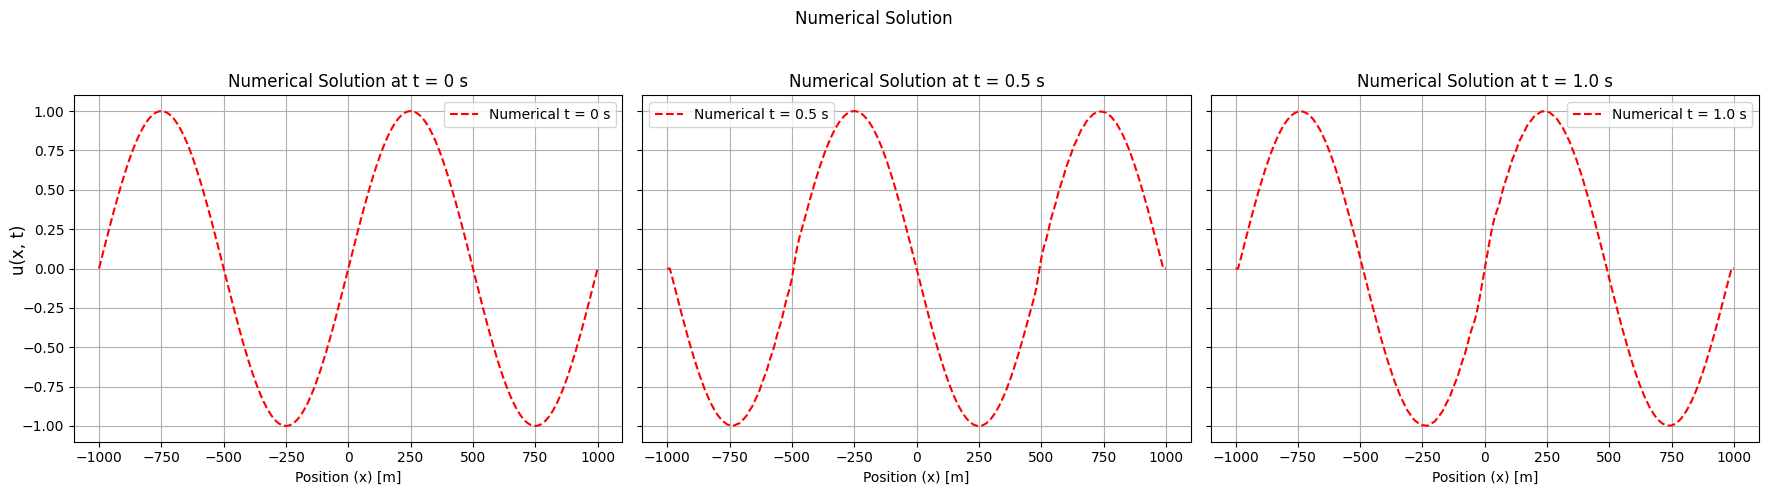

In [33]:
# Constants
L = 1000                 # Half-length of the domain in meters
c = 1000                 # Wave speed in m/s
N = 201                  # Number of spatial points
dx = 2 * L / (N - 1)     # Spatial step size for [-L, L] domain
dt = 0.6 * dx / c        # Time step size (CFL condition)
T = 1.0                  # Total simulation time in seconds
x = np.linspace(-L, L, N) # Spatial grid

# Total time steps
Nt = int(T / dt) + 1

# Initialize the wave field
u = np.sin(2 * np.pi * x / L)        # Initial condition u(x, 0)
u_prev = u.copy()                    # Initial velocity is zero: u_t(x, 0) = 0, so u at t=-1 = u at t=0
u_next = np.zeros(N)                 # Placeholder for the next time step

# Storage for specific time indices based on dt intervals
# Store the solutions at integer time indices corresponding to t = 0, 0.5, and 1.0 seconds
time_steps = [0, int(0.5 / dt), int(1.0 / dt)]
u_num_at_t = {}

# Modified finite difference update using a 4th-order central difference for spatial derivative
for n in range(Nt):
    # Store results at specified time indices if required
    if n in time_steps:
        u_num_at_t[n] = u.copy()
    
    # Update u_next using 4th-order stencil for internal points
    for i in range(2, N - 2):
        u_next[i] = (2 * u[i] - u_prev[i] +
                     (c * dt / dx) ** 2 * (-u[i + 2] + 16 * u[i + 1] - 30 * u[i] + 16 * u[i - 1] - u[i - 2]) / 12)

    # Set boundary and ghost points to zero (fixed endpoints)
    u_next[0] = u_next[1] = u_next[-1] = u_next[-2] = 0

    # Shift the time steps for the next iteration
    u_prev = u.copy()
    u = u_next.copy()


# Analytical Solution
def analytical_solution(x, t, c, L):
    return np.cos(2 * np.pi * c * t / L) * np.sin(2 * np.pi * x / L)

## Plotting the analytical solution
fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, t in enumerate([0, 0.5, 1.0]):
    # Analytical solution at time t
    u_analytic = analytical_solution(x, t, c, L)
    axs1[i].plot(x, u_analytic, 'k-', label=f"Analytical t = {t} s")

    # Plot formatting
    axs1[i].set_xlabel("Position (x) [m]")
    axs1[i].set_title(f"Analytical Solution at t = {t} s")
    axs1[i].legend()
    axs1[i].grid(True)

# Set global y-axis label
fig1.supylabel("u(x, t)")
fig1.suptitle("Analytical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Plotting the numerical solution
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
# Map the specified times to the stored integer time indices
time_map = {0: 0, 0.5: int(0.5 / dt), 1.0: int(1.0 / dt)}

for i, t in enumerate([0, 0.5, 1.0]):
    # Retrieve the numerical solution for the mapped time index
    u_num = u_num_at_t[time_map[t]]
    axs2[i].plot(x, u_num, 'r--', label=f"Numerical t = {t} s")

    # Plot formatting
    axs2[i].set_xlabel("Position (x) [m]")
    axs2[i].set_title(f"Numerical Solution at t = {t} s")
    axs2[i].legend()
    axs2[i].grid(True)

# Set global y-axis label
fig2.supylabel("u(x, t)")
fig2.suptitle("Numerical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [34]:
# Define tolerances
rtol = 1e-4
atol = 1e-5

# Times to check
times_to_check = [0, 0.5, 1.0]
time_map = {0: 0, 0.5: int(0.5 / dt), 1.0: int(1.0 / dt)}

# Check if numerical and analytical solutions match and report differences
for t in times_to_check:
    # Numerical and analytical solutions at this time step
    u_num = u_num_at_t[time_map[t]]
    u_analytic = analytical_solution(x, t, c, L)
    
    # Check if they are close
    is_close = np.all(np.isclose(u_num, u_analytic, rtol=rtol, atol=atol))
    
    if not is_close:
        # Calculate different error metrics
        max_abs_error = np.max(np.abs(u_num - u_analytic))
        mean_abs_error = np.mean(np.abs(u_num - u_analytic))
        rmse = np.sqrt(np.mean((u_num - u_analytic) ** 2))
        relative_error = np.mean(np.abs((u_num - u_analytic) / (u_analytic + 1e-10))) * 100  # avoid division by zero
        
        print(f"At t = {t} s:")
        print(f"  - Max Absolute Error: {max_abs_error:.6f}")
        print(f"  - Mean Absolute Error (MAE): {mean_abs_error:.6f}")
        print(f"  - Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"  - Average Relative Error: {relative_error:.2f}%")
    else:
        print(f"At t = {t} s: Numerical and analytical solutions are within tolerance.")


At t = 0 s: Numerical and analytical solutions are within tolerance.
At t = 0.5 s:
  - Max Absolute Error: 0.070090
  - Mean Absolute Error (MAE): 0.021733
  - Root Mean Squared Error (RMSE): 0.033583
  - Average Relative Error: 614951819.44%
At t = 1.0 s:
  - Max Absolute Error: 0.078894
  - Mean Absolute Error (MAE): 0.041835
  - Root Mean Squared Error (RMSE): 0.046952
  - Average Relative Error: 682698690.22%


In [35]:
def wave_solver(t_step, c, dx, dt, L, N, T):
    """
    Solves the 1D wave equation using a finite difference method.
    
    Parameters:
        t_step (float): Target time to calculate the wave field.
        c (float): Wave speed.
        dx (float): Spatial step size.
        dt (float): Time step size.
        L (float): Half-length of the domain in meters.
        N (int): Number of spatial points.
        T (float): Total simulation time in seconds.
        
    Returns:
        np.ndarray: Wave field at the specified time step.
    """
    Nt = int(T / dt) + 1  # Total time steps
    target_index = int(t_step / dt)  # Target time step index
    
    # Initialize the wave field
    x = np.linspace(-L, L, N)
    u = np.sin(2 * np.pi * x / L)        # Initial condition u(x, 0)
    u_prev = u.copy()                    # Initial velocity is zero: u_t(x, 0) = 0
    u_next = np.zeros(N)                 # Placeholder for the next time step

    # Main time evolution loop
    for n in range(Nt):
        # If we reach the target time step, return the current wave field
        if n == target_index:
            return u.copy()
        
        # Compute the next time step using finite difference
        for i in range(1, N - 1):
            u_next[i] = (2 * u[i] - u_prev[i] +
                         (c * dt / dx) ** 2 * (u[i + 1] - 2 * u[i] + u[i - 1]))
        
        # Apply boundary conditions
        u_next[0] = u_next[-1] = 0

        # Update arrays for the next time step
        u_prev = u.copy()
        u = u_next.copy()
    
    # If the loop completes without finding the target step, return the final state
    return u.copy()

# Parameters
L = 1000                  # Half-length of the domain in meters
c = 1000                  # Wave speed in m/s
N = 201                   # Number of spatial points
dx = 2 * L / (N - 1)      # Spatial step size for [-L, L] domain
dt = 0.9 * dx / c         # Time step size (CFL condition)
T = 1.0                   # Total simulation time in seconds
Nt = int(T / dt) + 1      # Total number of time steps
x = np.linspace(-L, L, N)

# loop through time steps, find numerical solution, subtract it from analytical solution, record (+=)

# Initialize variables to store cumulative error and the list of errors at each time step
cumulative_error = 0.0
cumulative_errors = []
errors = []

# Loop through each time step to calculate numerical and analytical solutions and accumulate the error
for n in range(Nt):
    t = n * dt  # Current time step
    
    # Calculate the numerical solution at the current time step using the wave_solver function
    numerical_solution = wave_solver(t, c, dx, dt, L, N, T)
    
    # Calculate the analytical solution at this time step
    analytical_solution = u(x, t, c, L)
    
    # Calculate the error (absolute difference between numerical and analytical solutions)
    error = np.abs(numerical_solution - analytical_solution)
    
    # Sum the error for this time step to the cumulative error
    cumulative_error += np.sum(error)
    errors.append(error)
    cumulative_errors.append(cumulative_error)

# Example plot: Cumulative Error vs. Time
time_values = np.arange(Nt) * dt  # Time array from 0 to T in steps of dt

# Plot cumulative error over time
plt.figure(figsize=(10, 6))
plt.plot(time_values, cumulative_errors, label="Cumulative Error", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Cumulative Error")
plt.title("Cumulative Error vs. Time")
plt.legend()
plt.grid()
plt.show()
print('Average error per time step:', np.mean(np.abs(errors)))


TypeError: 'numpy.ndarray' object is not callable